# Introduction

This project is about preprocessing and explorating data analysis of SARS-Cov-2 data on a global scale using PySpark. The dataset was curated and is maintained by Our World in Data (OWiD).

## Import Libarairies

In [56]:
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import math
import pandas as pd #Only used for display purpose
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns
import inspect
import warnings
warnings.filterwarnings("ignore")

# Loading, Visualizing and Cleaning the data

## Loading the data

In [57]:
file = 'owid-covid-data.csv'

spark = SparkSession.builder.appName("Covid Data").config('spark.sql.debug.maxToStringFields', 2000).getOrCreate()
full_df = spark.read.csv(file, header=True, inferSchema=True)

print(f"The number of samples is {full_df.count()}, with each sample corresponding to {len(full_df.columns)} features.")

The number of samples is 176224, with each sample corresponding to 67 features.


## Visualizing the data

In [58]:
# Display of samples
full_df.show(5)

+--------+---------+-----------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+-------------------------------

In [59]:
# Printing of the dataset features
full_df.printSchema()

root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: date (nullable = true)
 |-- total_cases: double (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: double (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: double (nullable = true)
 |-- hosp_patients_per_million: 

In [60]:
# Display of features NULL values
full_df.select("iso_code","location","continent","date","total_deaths").show(5)

+--------+-----------+---------+----------+------------+
|iso_code|   location|continent|      date|total_deaths|
+--------+-----------+---------+----------+------------+
|     AFG|Afghanistan|     Asia|2020-02-24|        NULL|
|     AFG|Afghanistan|     Asia|2020-02-25|        NULL|
|     AFG|Afghanistan|     Asia|2020-02-26|        NULL|
|     AFG|Afghanistan|     Asia|2020-02-27|        NULL|
|     AFG|Afghanistan|     Asia|2020-02-28|        NULL|
+--------+-----------+---------+----------+------------+
only showing top 5 rows



## Cleaning the data

As we just saw above this dataset tries to be quite exhaustive but there is still some information missing. In this part we will clean the dataset to make it easier to work on.

### Filtering the data

The dataset is quite huge so we will reduce it to a span of a few month (January to February 2021). It will reduce the data volume and speed up the following computation.

In [61]:
full_df = full_df.withColumn('date',F.to_date(F.unix_timestamp(F.col('date'), 'yyyy-MM-dd').cast("timestamp")))
dates = ("2021-01-01", "2021-02-28")
df = full_df.where(F.col('date').between(*dates))
print(f"The number of samples is now {df.count()} against the previous {full_df.count()}.")

The number of samples is now 13515 against the previous 176224.


### NULL Values

As we saw there is a lot of null values, we will try to fill all those gaps.

In [62]:
null_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in full_df.columns]).collect()[0].asDict()
null_vals = dict(sorted(null_vals.items(), reverse=True, key=lambda item: item[1]))

pd.DataFrame.from_records([null_vals])

,weekly_icu_admissions,weekly_icu_admissions_per_million,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,total_boosters,total_boosters_per_hundred,weekly_hosp_admissions,weekly_hosp_admissions_per_million,...,new_cases_smoothed_per_million,new_cases_per_million,total_cases_per_million,new_cases_smoothed,new_cases,total_cases,population,iso_code,location,date
0,13029,13029,13010,13010,13010,13010,12765,12765,12581,12581,...,412,382,378,353,323,319,105,0,0,0


We will start with the features which are not a double type. For exemple for the continent name we can change the NULL value to 'Unknown'.

In [63]:
df.sort("continent").select("iso_code","continent","location").show(5)
df = df.fillna({'continent':'Unknown'})
df.sort("continent").select("iso_code","continent","location").show(5)

+--------+---------+-------------+
|iso_code|continent|     location|
+--------+---------+-------------+
|OWID_NAM|     NULL|North America|
|OWID_AFR|     NULL|       Africa|
|OWID_NAM|     NULL|North America|
|OWID_AFR|     NULL|       Africa|
|OWID_NAM|     NULL|North America|
+--------+---------+-------------+
only showing top 5 rows

+--------+---------+----------+
|iso_code|continent|  location|
+--------+---------+----------+
|     MDG|   Africa|Madagascar|
|     DZA|   Africa|   Algeria|
|     MDG|   Africa|Madagascar|
|     DZA|   Africa|   Algeria|
|     MDG|   Africa|Madagascar|
+--------+---------+----------+
only showing top 5 rows



Then we can fix the missing values for the test unit features.

In [64]:
df.select("tests_units").distinct().show()
df = df.fillna({'tests_units':'no info'})
df.select("tests_units").distinct().show()

+---------------+
|    tests_units|
+---------------+
|  people tested|
| samples tested|
|tests performed|
|  units unclear|
|           NULL|
+---------------+

+---------------+
|    tests_units|
+---------------+
|  people tested|
| samples tested|
|tests performed|
|  units unclear|
|        no info|
+---------------+



Finaly for the missing double value we will just set it to 0.

In [65]:
df = df.fillna(0)

Final check :

In [66]:
null_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
pd.DataFrame.from_records([null_vals])

if any(list(null_vals.values())) != 0:
    print("There are still missing values in the DataFrame.")
    pd.DataFrame.from_records([null_vals])
else:
    print("There no longer a missing value in the DataFrame.")

There no longer a missing value in the DataFrame.


### Duplicate entries

To further reduce the size of the Dataframe we will check if there are duplicate entries in the dataset.

In [67]:
if df.count() != df.select(['location','date']).distinct().count():
    print("There are duplicate entries present in the DataFrame.")
else:
    print("There are no duplicate entries present in the DataFrame.")

There are no duplicate entries present in the DataFrame.


### Removing some "Country"

Some of the inputs are interesting such as World, High income, Lower income or European Union... But we will remove them to stick to the "classical" countries.

In [68]:
specific_countries = ["World", "High income", "Upper middle income","Lower middle income","Asia","Africa","Oceania","Europe","European Union","North America","South America"]

df = df.filter(~col("location").isin(specific_countries))

# Exploration of the data

## Functions

In [69]:
top_range=20

In [70]:
# Function to compute the top 20 regarding a specific feature in january and february
def compute_top_20(df,feature):

  january_cases = df.filter(F.col('date') == "2021-01-01").orderBy(feature, ascending=False).select(["location",feature]).take(top_range)
  february_cases = df.filter(F.col('date') == "2021-02-01").orderBy(feature, ascending=False).select(["location",feature]).take(top_range)

  return january_cases,february_cases

In [71]:
# Function to print the top 20 regarding a specific feature in january and february
def display_top_20(feature,january,february):

  # Extract country names and total cases from January and February
  january_countries = [x[0] for x in january]
  february_countries = [x[0] for x in february]

  # Determine the maximum length of country names for formatting
  max_country_length = max(max(len(country) for country in january_countries),
                           max(len(country) for country in february_countries))

  print(f"During 2021-01-01, the top {top_range} countries with the highest number of {feature} were:")
  for country, instance in january:
    print(f"▶ {country.ljust(max_country_length)}, with {int(instance)} {feature}.")

  print("")

  print(f"During 2021-01-01, the top {top_range} countries with the highest number of {feature} were:")
  for country, instance in february:
    print(f"▶ {country.ljust(max_country_length)}, with {int(instance)} {feature}.")

In [72]:
# Function to display difference in rankings between january and february
def display_diff_top_20(feature, january, february):

  # Extract country names and total cases from January and February
  january_countries = [x[0] for x in january]
  february_countries = [x[0] for x in february]

  # Create dictionaries to map countries to their rankings
  january_rankings = {country: rank + 1 for rank, country in enumerate(january_countries)}
  february_rankings = {country: rank + 1 for rank, country in enumerate(february_countries)}

  # Determine the maximum length of country names for formatting
  max_country_length = max(max(len(country) for country in january_countries),
                           max(len(country) for country in february_countries))

  # Display the modification in rankings
  print("Modification in total cases Rankings between January and February:")
  for country in january_countries:
    january_rank = january_rankings[country]
    february_rank = february_rankings.get(country, f"Not in Top {top_range}")
    if february_rank != f"Not in Top {top_range}":
      change = january_rank - february_rank
      if change != 0:
        if change > 0:
          change_str = f"↑ Moved up by {change} position(s) from {january_rank} to {february_rank}"
        elif change < 0:
          change_str = f"↓ Moved down by {-change} position(s) from {january_rank} to {february_rank}"
        # Format the output for alignment
        print(f"{country.ljust(max_country_length)}: {change_str}")
    else:
      print(f"{country.ljust(max_country_length)}: No longer in February Top {top_range}")

  # Check if any new entries appeared in February Top 20
  new_entries = set(february_countries) - set(january_countries)
  for country in new_entries:
    february_rank = february_rankings[country]
    # Format the output for alignment
    print(f"{country.ljust(max_country_length)}: New entry at position {february_rank}")

In [73]:
# Function to print the top 20 regarding a specific rate in january and february
def display_top_20_rate(feature,january,february):

  # Extract country names and total cases from January and February
  january_countries = [x[0] for x in january]
  february_countries = [x[0] for x in february]

  # Determine the maximum length of country names for formatting
  max_country_length = max(max(len(country) for country in january_countries),
                           max(len(country) for country in february_countries))

  print(f"During 2021-01-01, the top {top_range} countries with the highest number of {feature} were:")
  for country, instance in january:
    print(f"▶ {country.ljust(max_country_length)}, with {'{:.2f}'.format(instance * 100)}% of {feature}.")

  print("")

  print(f"During 2021-01-01, the top {top_range} countries with the highest number of {feature} were:")
  for country, instance in february:
    print(f"▶ {country.ljust(max_country_length)}, with {'{:.2f}'.format(instance * 100)}% of {feature}.")


In [74]:
# Function to display the evolution of two features every 3 days from january to february
def display_evol(feature_1,feature_2,label_1,label_2):

  # Adjusting dates and ticks for every 3 days
  dates_frame = df.select("date").distinct().orderBy('date').collect()
  dates_list = [str(dates_frame[x][0]) for x in range(len(dates_frame))]

  alt_dts_list = [dt.replace('2021-', '') for i, dt in enumerate(dates_list) if i % 3 == 0]
  tick_marks = np.arange(len(alt_dts_list) * 3, 3)

  # Plotting
  sns.set(style="darkgrid")
  fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 5))

  # Plot for feature_1
  ax1.plot(alt_dts_list, feature_1[::3], marker='o', color='b')
  ax1.set_title(f'{label_1} over Time')
  ax1.set_xlabel('Date')
  ax1.set_ylabel(f'{label_1}')

  # Plot for feature_2
  ax2.plot(alt_dts_list, feature_2[::3], marker='o', color='r')
  ax2.set_title(f'{label_2} over Time')
  ax2.set_xlabel('Date')
  ax2.set_ylabel(f'{label_2}')

  # Rotate x-axis labels for better visibility
  plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
  plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

  plt.tight_layout()
  plt.show()

In [75]:
# Function to display the evolutiondifference of two features from january to february in an hist diagramme
def display_diff_january_february(feature,january,february, countries):

  # Plotting
  width = 0.35  # Width of the bars
  x = np.arange(len(countries))  # X-axis positions

  fig, ax = plt.subplots(figsize=(12, 6))

  # Plotting bars for January
  ax.bar(x - width/2, january, width, label='January', alpha=0.7)

  # Plotting bars for February
  ax.bar(x + width/2,february, width, label='February', alpha=0.7)

  # Setting labels and title
  ax.set_xlabel('Country')
  ax.set_ylabel(f'{feature}')
  ax.set_title(f'{feature} Comparison (January vs. February)')
  ax.set_xticks(x)
  ax.set_xticklabels(countries, rotation=90)
  ax.legend()

  plt.tight_layout()
  plt.show()

In [76]:
# Function to set the color of the corelation matrix
def CustomCmap(from_rgb,to_rgb):

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

mycmap = CustomCmap([1.0, 1.0, 1.0], [72/255, 99/255, 147/255])

In [77]:
# Function to display the difference
def compute_health_conditions(country_list):

  # Compute the differences from mean values
  country_list['Female Smokers (%)'] = country_list['female_smokers'] - mean_female_smokers
  country_list['Male Smokers (%)'] = country_list['male_smokers'] - mean_male_smokers
  country_list['Diabetic Population (%)'] = country_list['diabetes_prevalence'] - mean_diabetes_prevalence
  country_list['Cardiovascular-related Deaths per 100.000 (%)'] = country_list['cardiovasc_death_rate'] - mean_cardiovasc_death_rate

  # Highlight entries higher than mean values in red
  highlighted_cols = ['Female Smokers (%)', 'Male Smokers (%)', 'Diabetic Population (%)', 'Cardiovascular-related Deaths per 100.000 (%)']
  country_list[highlighted_cols] = country_list[highlighted_cols].applymap(lambda x: f'\033[91m{x:.2f}\033[0m' if x > 0 else f'{x:.2f}')

  # Create a new DataFrame with only the computed features
  computed_features_df = country_list[['location', 'Female Smokers (%)', 'Male Smokers (%)', 'Diabetic Population (%)', 'Cardiovascular-related Deaths per 100.000 (%)']]

  # Display the result
  pd.set_option('display.width', 1000)
  print(computed_features_df)

## Top of total cases (Easy)

In [78]:
# Compute top 20 for total cases per country
january_cases, february_cases = compute_top_20(df,"total_cases")
# Display top 20
display_top_20("total_cases",january_cases, february_cases)
# Display differences in rankings
print("")
display_diff_top_20("total_cases",january_cases, february_cases)

During 2021-01-01, the top 20 countries with the highest number of total_cases were:
▶ United States , with 20370964 total_cases.
▶ India         , with 10305788 total_cases.
▶ Brazil        , with 7703971 total_cases.
▶ Russia        , with 3153960 total_cases.
▶ France        , with 2680034 total_cases.
▶ United Kingdom, with 2545102 total_cases.
▶ Turkey        , with 2220855 total_cases.
▶ Italy         , with 2129376 total_cases.
▶ Spain         , with 1928265 total_cases.
▶ Germany       , with 1742661 total_cases.
▶ Colombia      , with 1654880 total_cases.
▶ Argentina     , with 1629594 total_cases.
▶ Mexico        , with 1437185 total_cases.
▶ Poland        , with 1305774 total_cases.
▶ Iran          , with 1231429 total_cases.
▶ Ukraine       , with 1096855 total_cases.
▶ South Africa  , with 1073887 total_cases.
▶ Peru          , with 1015137 total_cases.
▶ Netherlands   , with 815223 total_cases.
▶ Indonesia     , with 751270 total_cases.

During 2021-01-01, the top 20 coun

## Top of number of new test (Easy)

In [79]:
# Compute top 20 for total cases per country
january_test, february_test = compute_top_20(df,"new_tests")
# Display top 20
display_top_20("new_tests",january_test, february_test)
# Display differences in rankings
print("")
display_diff_top_20("new_tests",january_test, february_test)

During 2021-01-01, the top 20 countries with the highest number of new_tests were:
▶ United States       , with 1257252 new_tests.
▶ India               , with 1062420 new_tests.
▶ United Kingdom      , with 404917 new_tests.
▶ Russia              , with 386001 new_tests.
▶ Turkey              , with 158103 new_tests.
▶ Italy               , with 157524 new_tests.
▶ United Arab Emirates, with 145163 new_tests.
▶ Canada              , with 132528 new_tests.
▶ South Korea         , with 101176 new_tests.
▶ Israel              , with 95925 new_tests.
▶ Australia           , with 56346 new_tests.
▶ Spain               , with 53318 new_tests.
▶ Chile               , with 50583 new_tests.
▶ South Africa        , with 50110 new_tests.
▶ Iran                , with 49601 new_tests.
▶ Pakistan            , with 41039 new_tests.
▶ Malaysia            , with 39641 new_tests.
▶ Colombia            , with 38942 new_tests.
▶ Netherlands         , with 33272 new_tests.
▶ France              , with 332

In [80]:
world_test_january = int(df.filter(F.col('date') == "2021-01-01").groupBy("date").agg(F.sum("new_tests")).collect()[0][1])
print("To 2021-01-01, the total number of new tests in the world was:", world_test_january)

world_test_february = int(df.filter(F.col('date') == "2021-02-01").groupBy("date").agg(F.sum("new_tests")).collect()[0][1])
print("To 2021-02-01, the total number of new tests in the world was:", world_test_february)

print(f"Which means that in one month {world_test_february - world_test_january} new tests were performed")

To 2021-01-01, the total number of new tests in the world was: 4945841
To 2021-02-01, the total number of new tests in the world was: 5470131
Which means that in one month 524290 new tests were performed


## Evolution of mortality in top countries (Intermediate)

In this part we will compute the mortality rate (number of death / number of covid case) for each country and sort the top 20.

In [81]:
df_mortality_case = df.filter(F.col('population') != 0.0).withColumn("mortality_per_case", F.col("total_deaths")/F.col("total_cases"))

# Compute top 20 for total cases per country
january_mort_cases, february_mort_cases = compute_top_20(df_mortality_case,"mortality_per_case")
# Display top 20
display_top_20_rate("mortality_per_case",january_mort_cases, february_mort_cases)
# Display differences in rankings
print("")
display_diff_top_20("mortality_per_case",january_mort_cases, february_mort_cases)

During 2021-01-01, the top 20 countries with the highest number of mortality_per_case were:
▶ Yemen                 , with 29.03% of mortality_per_case.
▶ Peru                  , with 9.18% of mortality_per_case.
▶ Mexico                , with 8.80% of mortality_per_case.
▶ Montserrat            , with 7.69% of mortality_per_case.
▶ Isle of Man           , with 6.63% of mortality_per_case.
▶ Ecuador               , with 6.59% of mortality_per_case.
▶ Syria                 , with 6.22% of mortality_per_case.
▶ Sudan                 , with 5.71% of mortality_per_case.
▶ Bolivia               , with 5.70% of mortality_per_case.
▶ Egypt                 , with 5.51% of mortality_per_case.
▶ China                 , with 4.94% of mortality_per_case.
▶ Chad                  , with 4.86% of mortality_per_case.
▶ Liberia               , with 4.61% of mortality_per_case.
▶ Iran                  , with 4.49% of mortality_per_case.
▶ Afghanistan           , with 4.19% of mortality_per_case.
▶ Tanza

In this part we will compute antoher mortality rate (number of death / populations) for each country and sort the top 20 to compare it to the previous top 20.

In [82]:
df_mortality_pop = df.filter(F.col('population') != 0.0).withColumn("mortality_per_pop", F.col("total_deaths")/F.col("population"))

# Compute top 20 for total cases per country
january_mort_pop, february_mort_pop = compute_top_20(df_mortality_pop,"mortality_per_pop")
# Display top 20
display_top_20_rate("mortality_per_pop",january_mort_pop, february_mort_pop)
# Display differences in rankings
print("")
display_diff_top_20("mortality_per_pop",january_mort_pop, february_mort_pop)

During 2021-01-01, the top 20 countries with the highest number of mortality_per_pop were:
▶ Peru                  , with 0.28% of mortality_per_pop.
▶ San Marino            , with 0.17% of mortality_per_pop.
▶ Belgium               , with 0.17% of mortality_per_pop.
▶ Slovenia              , with 0.13% of mortality_per_pop.
▶ Bosnia and Herzegovina, with 0.13% of mortality_per_pop.
▶ Italy                 , with 0.12% of mortality_per_pop.
▶ North Macedonia       , with 0.12% of mortality_per_pop.
▶ Liechtenstein         , with 0.12% of mortality_per_pop.
▶ Bulgaria              , with 0.11% of mortality_per_pop.
▶ Czechia               , with 0.11% of mortality_per_pop.
▶ Montenegro            , with 0.11% of mortality_per_pop.
▶ United Kingdom        , with 0.11% of mortality_per_pop.
▶ Spain                 , with 0.11% of mortality_per_pop.
▶ Andorra               , with 0.11% of mortality_per_pop.
▶ United States         , with 0.11% of mortality_per_pop.
▶ Hungary               

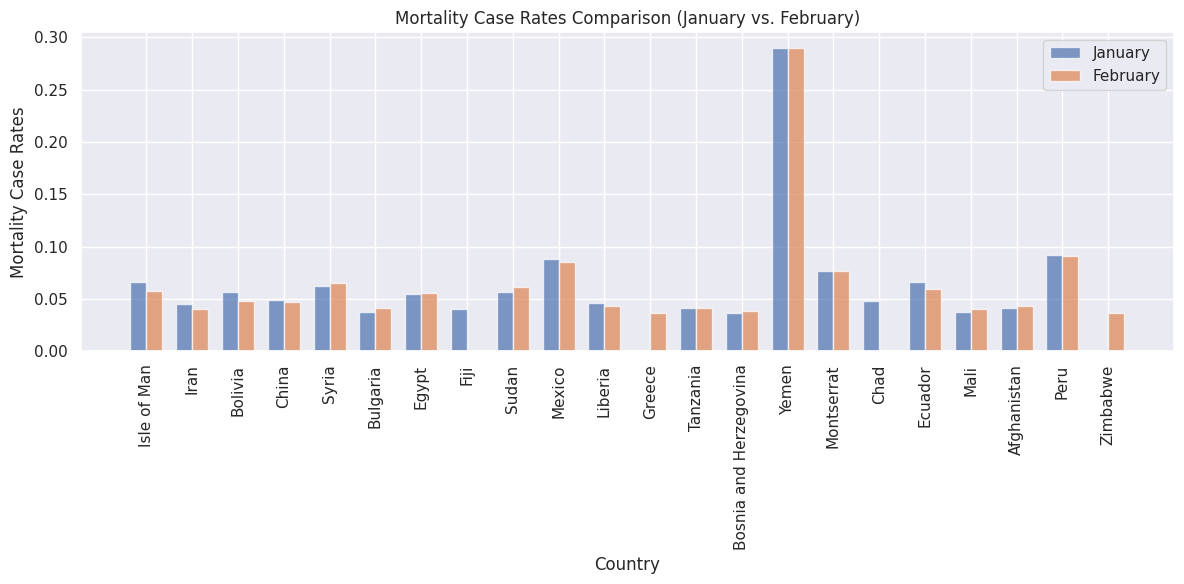

In [83]:
# Extracting countries and their mortality rates from the top 20 lists

countries_january = [x[0] for x in january_mort_cases]
countries_february = [x[0] for x in february_mort_cases]

# Create a dictionary to map countries to their positions
all_countries = set(countries_january + countries_february)
country_to_index = {country: index for index, country in enumerate(all_countries)}

# Create an array to store mortality rates for each month and initialize with zeros
merged_mortality_case_january = [0] * len(all_countries)
merged_mortality_case_february = [0] * len(all_countries)

# Fill the merged arrays with mortality rates
for country, mortality in january_mort_cases:
    merged_mortality_case_january[country_to_index[country]] = mortality

for country, mortality in february_mort_cases:
    merged_mortality_case_february[country_to_index[country]] = mortality

display_diff_january_february("Mortality Case Rates",merged_mortality_case_january,merged_mortality_case_february, all_countries)

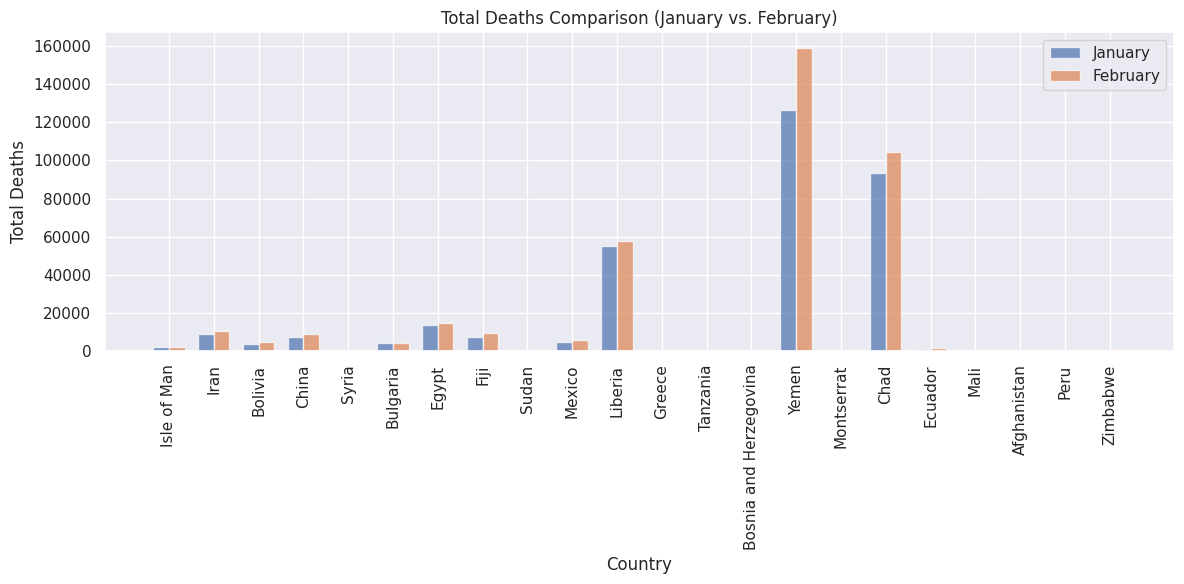

In [84]:
# Filter DataFrame for January date and select only countries in all_countries
january_deaths = df.filter((F.col('date') == "2021-01-01") & (F.col('location').isin(all_countries))) \
                   .select(["location", "total_deaths"]) \
                   .take(len(all_countries))

# Filter DataFrame for February date and select only countries in all_countries
february_deaths = df.filter((F.col('date') == "2021-02-01") & (F.col('location').isin(all_countries))) \
                    .select(["location", "total_deaths"]) \
                    .take(len(all_countries))

# Extracting country names and total deaths for January and February
january_countries, january_deaths_values = zip(*january_deaths)
february_countries, february_deaths_values = zip(*february_deaths)

display_diff_january_february("Total Deaths",january_deaths_values,february_deaths_values,all_countries)

## Evolution of patient admissions (Intermediate)

In [85]:
# Compute top 20 for total cases per country
january_test, february_test = compute_top_20(df,"icu_patients")
# Display top 20
display_top_20("icu_patients",january_test, february_test)
# Display differences in rankings
print("")
display_diff_top_20("icu_patients",january_test, february_test)

During 2021-01-01, the top 20 countries with the highest number of icu_patients were:
▶ United States , with 27471 icu_patients.
▶ Germany       , with 5604 icu_patients.
▶ France        , with 2609 icu_patients.
▶ Italy         , with 2553 icu_patients.
▶ United Kingdom, with 2162 icu_patients.
▶ Spain         , with 2085 icu_patients.
▶ Czechia       , with 952 icu_patients.
▶ Canada        , with 817 icu_patients.
▶ Chile         , with 794 icu_patients.
▶ Netherlands   , with 703 icu_patients.
▶ Belgium       , with 489 icu_patients.
▶ Portugal      , with 483 icu_patients.
▶ Bulgaria      , with 464 icu_patients.
▶ Switzerland   , with 421 icu_patients.
▶ Austria       , with 385 icu_patients.
▶ South Korea   , with 354 icu_patients.
▶ Sweden        , with 335 icu_patients.
▶ Serbia        , with 283 icu_patients.
▶ Slovakia      , with 245 icu_patients.
▶ Israel        , with 225 icu_patients.

During 2021-01-01, the top 20 countries with the highest number of icu_patients were:


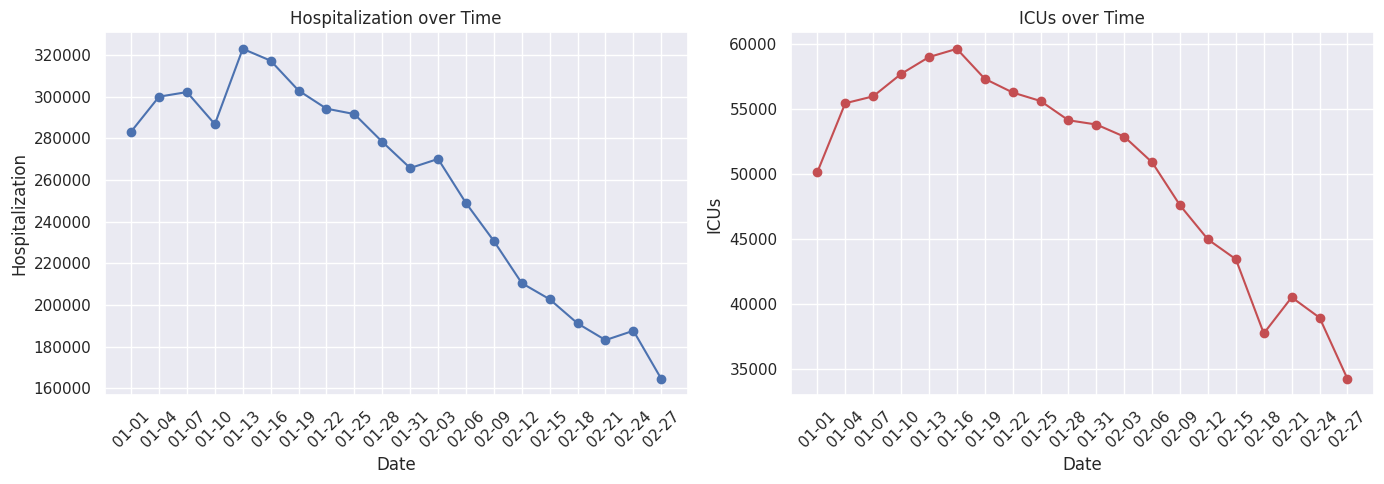

In [86]:
hosps = df.orderBy("date", ascending=True).groupBy("date").agg(F.sum("hosp_patients")).collect()
hosps = [hosps[i][1] for i in range(len(hosps))]

icus = df.orderBy("date", ascending=True).groupBy("date").agg(F.sum("icu_patients")).collect()
icus = [icus[i][1] for i in range(len(icus))]

display_evol(hosps,icus,"Hospitalization","ICUs")

## Comparison between the ICU patient and the death case (Intermediate)

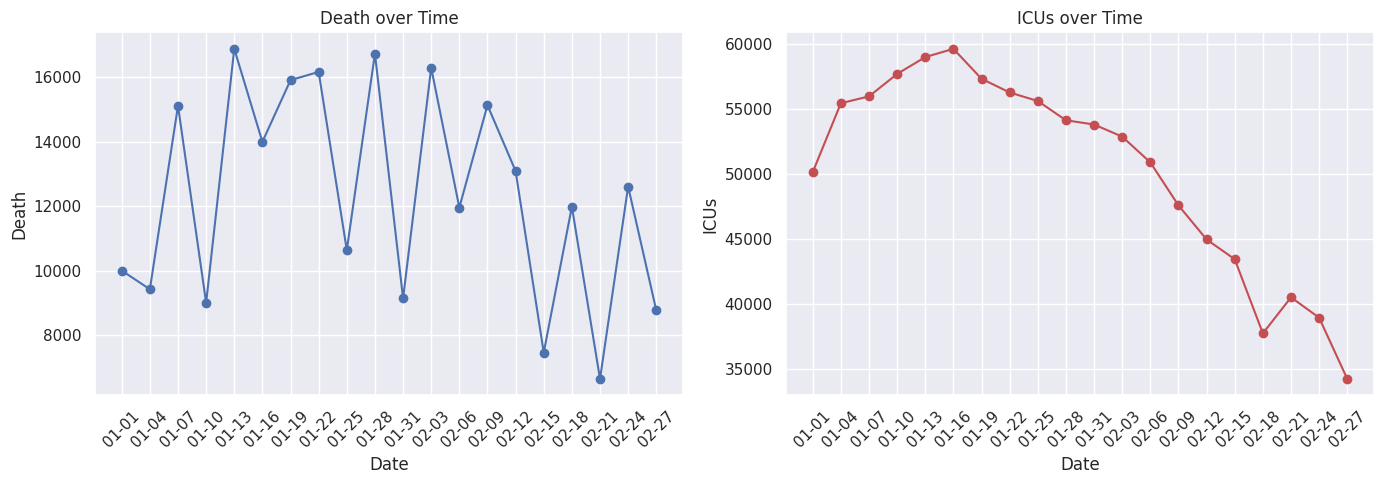

In [87]:
deaths = df.orderBy("date", ascending=True).groupBy("date").agg(F.sum("new_deaths")).collect()
deaths = [deaths[i][1] for i in range(len(deaths))]

display_evol(deaths,icus,"Death","ICUs")

## Geographic Correlation of Excess Mortality (Hard)

In this part we will study the correlation between differents features that can be linked to the excess mortality feature.

The excess mortality is a feature for which the reports are weekly and not daily. It is equal to the total number of deaths for a specific week minus the mean number of deaths, based on reports from previous years. While it is not a feature directly connected with Covid, it's expected that during a global pandemic the excess mortality can be mainly attributed to this pandemic.

In [88]:
exc_dates_list = df.filter(F.col('excess_mortality') != 0.0).select(['date']).distinct().orderBy('date').collect()
exc_dates_list = [str(exc_dates_list[i][0]) for i in range(len(exc_dates_list))]

european_df = df.filter(F.col('continent') == 'Europe').filter(F.col('excess_mortality') != 0.0)
european_cts = european_df.select(['location']).distinct().collect()
european_cts = [european_cts[i][0] for i in range(len(european_cts)) if european_df.filter(F.col('location') == european_cts[i][0]).count() == len(exc_dates_list)]
print(f'{len(european_cts)} European countries are chosen for this analysis.')

31 European countries are chosen for this analysis.


In [89]:
eu_cts_df = european_df.filter(F.col('location') == european_cts[0]).select(['excess_mortality']).withColumnRenamed("excess_mortality", european_cts[0])
# required for the proper join of the following DataFrames
eu_cts_df = eu_cts_df.withColumn('row_index', row_number().over(Window.partitionBy(F.lit(0)).orderBy(monotonically_increasing_id())))

for country in european_cts[1:]:
    new_ct_df = european_df.filter(F.col('location') == country).select(['excess_mortality']).withColumnRenamed("excess_mortality", country)
    new_ct_df = new_ct_df.withColumn('row_index', row_number().over(Window.partitionBy(F.lit(0)).orderBy(monotonically_increasing_id())))

    eu_cts_df = eu_cts_df.join(new_ct_df, on=["row_index"])

eu_cts_df = eu_cts_df.drop("row_index")

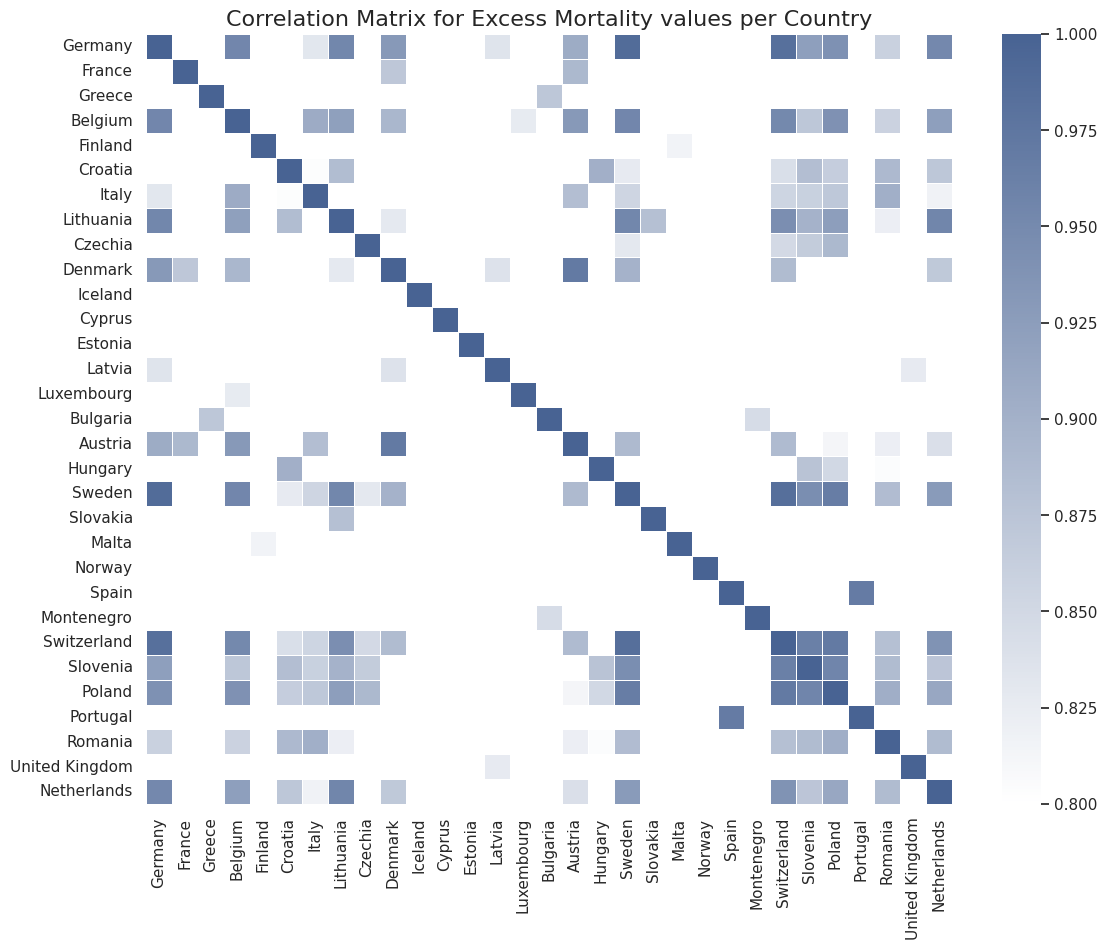

In [90]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=eu_cts_df.columns, outputCol=vector_col)
df_vector = assembler.transform(eu_cts_df).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col, 'pearson')
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

fig, ax = plt.subplots(figsize=(13,10))

sns.heatmap(cor_np, linewidths=.5, ax=ax, vmin=0.8, vmax=1, cmap=mycmap,
            xticklabels=european_cts, yticklabels=european_cts)
ax.set_title('Correlation Matrix for Excess Mortality values per Country', fontsize=16)
plt.show()

In [91]:
for i in range(len(european_cts)):
    for j in range(i+1,len(european_cts)):
        corr_val = cor_np[i][j]
        if corr_val > 0.95:
            print(f'{european_cts[i]} and {european_cts[j]} show a correlation of {100*corr_val:.2f}.')

Germany and Belgium show a correlation of 95.43.
Germany and Lithuania show a correlation of 95.35.
Germany and Sweden show a correlation of 98.87.
Germany and Switzerland show a correlation of 98.29.
Germany and Netherlands show a correlation of 95.19.
Belgium and Sweden show a correlation of 95.43.
Belgium and Switzerland show a correlation of 95.14.
Lithuania and Sweden show a correlation of 95.32.
Lithuania and Netherlands show a correlation of 95.47.
Denmark and Austria show a correlation of 97.06.
Sweden and Switzerland show a correlation of 98.40.
Sweden and Poland show a correlation of 96.59.
Spain and Portugal show a correlation of 96.87.
Switzerland and Slovenia show a correlation of 96.30.
Switzerland and Poland show a correlation of 96.98.
Slovenia and Poland show a correlation of 95.57.


## Correlation between different features (Hard)

In [92]:
countries_frame = df.select("location").distinct().collect()
countries_list = [str(countries_frame[x][0]) for x in range(len(countries_frame)) if str(countries_frame[x][0]) not in specific_countries]

#countries_list

In [93]:
country_dict = {}
for country in countries_list:
    filtered = df.filter(F.col('location') == country).filter(F.col('excess_mortality') != 0.0)
    if filtered.count() > 5:
        value = filtered.stat.corr("excess_mortality", "new_tests_smoothed")
    else:
        value = np.nan
    if not np.isnan(value):
        country_dict[country] = value

#country_dict

In [94]:
country_dict = dict(sorted(country_dict.items(), reverse=True, key=lambda item: item[1]))
print("As far as the correlation between new tests and excess mortality is concerned:\n")
print("The ten countries with the highest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")
country_dict = dict(sorted(country_dict.items(), reverse=False, key=lambda item: item[1]))
print("\nThe ten countries with the lowest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")

As far as the correlation between new tests and excess mortality is concerned:

The ten countries with the highest correlation are:
Spain, with correlation equal to 0.976.
South Africa, with correlation equal to 0.968.
Peru, with correlation equal to 0.962.
Portugal, with correlation equal to 0.960.
Mexico, with correlation equal to 0.921.
Colombia, with correlation equal to 0.916.
United States, with correlation equal to 0.794.
Lithuania, with correlation equal to 0.762.
South Korea, with correlation equal to 0.723.
Ecuador, with correlation equal to 0.670.

The ten countries with the lowest correlation are:
Slovakia, with correlation equal to -0.883.
Denmark, with correlation equal to -0.828.
Romania, with correlation equal to -0.762.
New Zealand, with correlation equal to -0.729.
Switzerland, with correlation equal to -0.715.
Italy, with correlation equal to -0.698.
Sweden, with correlation equal to -0.643.
Luxembourg, with correlation equal to -0.543.
Guatemala, with correlation eq

## Covid and general health conditions (Hard)

In [95]:
filtered_df = df.filter(F.col('date') == "2021-02-28")

mean_female_smokers = filtered_df.filter(F.col('female_smokers') != 0.0).select(F.mean(F.col('female_smokers'))).collect()[0][0]
mean_male_smokers = filtered_df.filter(F.col('male_smokers') != 0.0).select(F.mean(F.col('male_smokers'))).collect()[0][0]
mean_diabetes_prevalence = filtered_df.filter(F.col('diabetes_prevalence') != 0.0).select(F.mean(F.col('diabetes_prevalence'))).collect()[0][0]
mean_cardiovasc_death_rate = filtered_df.filter(F.col('cardiovasc_death_rate') != 0.0).select(F.mean(F.col('cardiovasc_death_rate'))).collect()[0][0]

print(f'Based on data up to 2021-01-01, the mean percentage of female smokers is {mean_female_smokers:.2f}%, while the corresponding number for male smokers is {mean_male_smokers:.2f}%.')
print(f'In addition, the mean percentage of people suffering from diabetes (aged 20-79) is {mean_diabetes_prevalence:.2f}%, while the mean number of deaths per 100.000 people due to cardiovascular conditions is {mean_card:.2f}.')

Based on data up to 2021-01-01, the mean percentage of female smokers is 10.43%, while the corresponding number for male smokers is 32.67%.
In addition, the mean percentage of people suffering from diabetes (aged 20-79) is 8.27%, while the mean number of deaths per 100.000 people due to cardiovascular conditions is 263.33.


In [97]:
filtered_df = filtered_df.filter(F.col('diabetes_prevalence') != 0.0).filter(F.col('cardiovasc_death_rate') != 0.0).filter(F.col('female_smokers') != 0.0).filter(F.col('male_smokers') != 0.0)
filtered_df.orderBy("excess_mortality_cumulative_per_million", ascending=False).select(["location", "excess_mortality_cumulative_per_million", "female_smokers", "male_smokers", "diabetes_prevalence", "cardiovasc_death_rate"]).toPandas().head(5)

,location,excess_mortality_cumulative_per_million,female_smokers,male_smokers,diabetes_prevalence,cardiovasc_death_rate
0,Armenia,3613.725554,1.5,52.1,7.11,341.010
1,Mexico,3437.694368,6.9,21.4,13.06,152.783
2,Belarus,3287.984465,10.5,46.1,5.18,443.129
3,Russia,3151.540865,23.4,58.3,6.18,431.297
4,Albania,2854.503445,7.1,51.2,10.08,304.195


In [98]:
# Top 5 countries with respect to excess mortality (per million)
top_5_countries = filtered_df.orderBy("excess_mortality_cumulative_per_million", ascending=False).select(
    "location",
    "excess_mortality_cumulative_per_million",
    "female_smokers",
    "male_smokers",
    "diabetes_prevalence",
    "cardiovasc_death_rate"
).limit(5).toPandas()

compute_health_conditions(top_5_countries)

  location Female Smokers (%) Male Smokers (%) Diabetic Population (%) Cardiovascular-related Deaths per 100.000 (%)
0  Armenia              -8.93   19.43                   -1.16                                77.68
1   Mexico              -3.53           -11.27           4.79                                       -110.55
2  Belarus      0.07   13.43                   -3.09                               179.80
3   Russia     12.97   25.63                   -2.09                               167.97
4  Albania              -3.33   18.53           1.81                                40.87


In [99]:
filtered_df.orderBy("excess_mortality_cumulative_per_million", ascending=True).select(["location", "excess_mortality_cumulative_per_million", "female_smokers", "male_smokers", "diabetes_prevalence", "cardiovasc_death_rate"]).toPandas().head(5)

,location,excess_mortality_cumulative_per_million,female_smokers,male_smokers,diabetes_prevalence,cardiovasc_death_rate
0,Seychelles,-1678.293398,7.1,35.7,10.55,242.648
1,Barbados,-832.093651,1.9,14.5,13.57,170.050
2,Uruguay,-682.380568,14.0,19.9,6.93,160.708
3,Mongolia,-605.836333,5.5,46.5,4.82,460.043
4,Malaysia,-465.227889,1.0,42.4,16.74,260.942


In [100]:
# Top 5 from last of countries with respect to excess mortality (per million)
top_5_last_countries = filtered_df.orderBy("excess_mortality_cumulative_per_million", ascending=True).select([
    "location",
    "excess_mortality_cumulative_per_million",
    "female_smokers",
    "male_smokers",
    "diabetes_prevalence",
    "cardiovasc_death_rate"]
).limit(5).toPandas()

compute_health_conditions(top_5_last_countries)

     location Female Smokers (%) Male Smokers (%) Diabetic Population (%) Cardiovascular-related Deaths per 100.000 (%)
0  Seychelles              -3.33    3.03           2.28                                        -20.68
1    Barbados              -8.53           -18.17           5.30                                        -93.28
2     Uruguay      3.57           -12.77                   -1.34                                       -102.62
3    Mongolia              -4.93   13.83                   -3.45                               196.71
4    Malaysia              -9.43    9.73           8.47                                         -2.39
